<a href="https://colab.research.google.com/github/uncodingthecode/ds_palash_shah/blob/main/notebook_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

In [ ]:
TRADE_CSV = "/content/csv_files/historical_data.csv"
FGI_CSV = "/content/csv_files/fear_greed_index.csv"
ROLLING_WINDOW = 30
ROLLING_CORR_WINDOW = 60
MAX_LAG = 30
REGIME_BINS = [-1, 40, 60, 999]

In [ ]:
def pick_col(df, candidates):
  for c in candidates:
    if c in df.columns:
      return c
  return None

In [ ]:
DATE_COL_TRADE_PREFERRED = ["Timestamp IST", "Timestamp", "timestamp", "time", "datetime"]
PROFIT_CANDIDATES = ["Closed PnL", "ClosedPnL", "profit", "pnl"]
VOLUME_CANDIDATES = ["Size USD", "Size Tokens", "volume", "qty"]
LEVERAGE_CANDIDATES = ["leverage", "Leverage"]
FGI_DATE_CANDIDATES = ["date", "timestamp", "time"]
FGI_VALUE_CANDIDATES = ["value", "fgi", "index", "score"]

Loading Trades

In [ ]:
trades = pd.read_csv(TRADE_CSV)

Detect Columns

In [ ]:
trade_date_col = pick_col(trades, DATE_COL_TRADE_PREFERRED)
profit_col = pick_col(trades, PROFIT_CANDIDATES)
volume_col = pick_col(trades, VOLUME_CANDIDATES)
lev_col = pick_col(trades, LEVERAGE_CANDIDATES)

Parse DateTime

In [ ]:
trades[trade_date_col] = pd.to_datetime(trades[trade_date_col], errors='coerce')
trades[profit_col] = pd.to_numeric(trades[profit_col], errors='coerce').fillna(0)
trades[volume_col] = pd.to_numeric(trades[volume_col], errors='coerce').fillna(0)
if lev_col:
  trades[lev_col] = pd.to_numeric(trades[lev_col], errors='coerce')

Loading Fear Greed Index csv (fgi)

In [ ]:
fgi = pd.read_csv(FGI_CSV)
fgi_date_col = pick_col(fgi, FGI_DATE_CANDIDATES)
fgi_val_col = pick_col(fgi, FGI_VALUE_CANDIDATES)
fgi[fgi_date_col] = pd.to_datetime(fgi[fgi_date_col], errors='coerce')
fgi = fgi.rename(columns={fgi_date_col: 'date', fgi_val_col: 'fgi'})
fgi['date'] = fgi['date'].dt.floor('D')

Exploratory Data Analysis (EDA)

Trades Dataset Overview


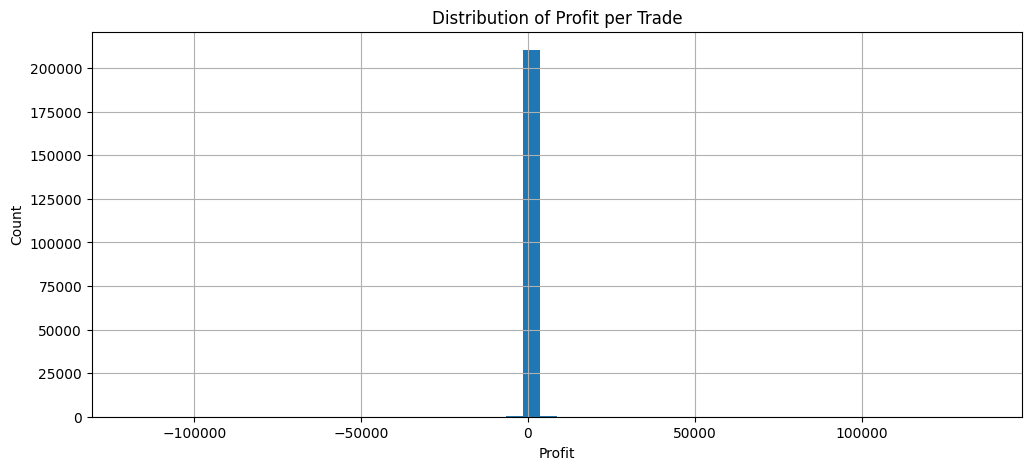

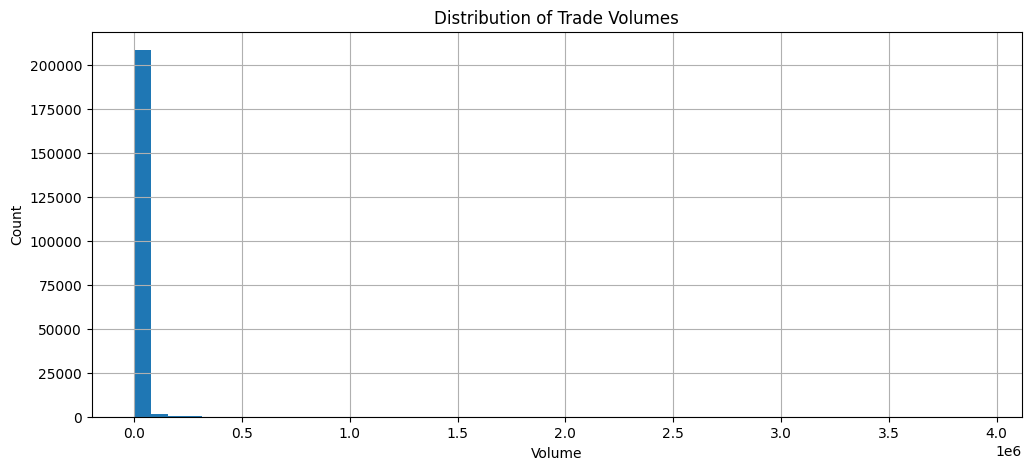

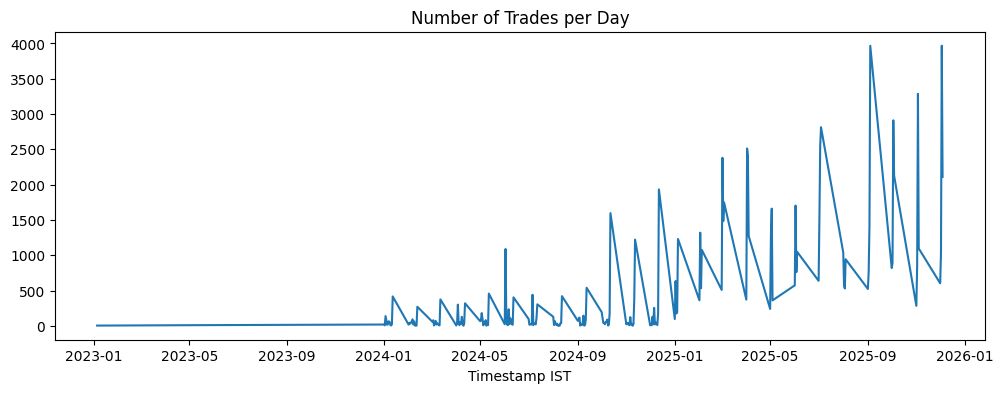


FGI Dataset Overview
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   timestamp       2644 non-null   int64         
 1   fgi             2644 non-null   int64         
 2   classification  2644 non-null   object        
 3   date            2644 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 82.8+ KB
None


,timestamp,fgi,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05



Summary Statistics (FGI)


,timestamp,fgi,date
count,2.644000e+03,2644.000,2644
mean,1.631899e+09,46.981,2021-09-17 11:44:45.022692864
min,1.517463e+09,5.000,2018-02-01 00:00:00
25%,1.574811e+09,28.000,2019-11-26 18:00:00
50%,1.631900e+09,46.000,2021-09-17 12:00:00
75%,1.688989e+09,66.000,2023-07-10 06:00:00
max,1.746164e+09,95.000,2025-05-02 00:00:00
std,6.597967e+07,21.828,NaN


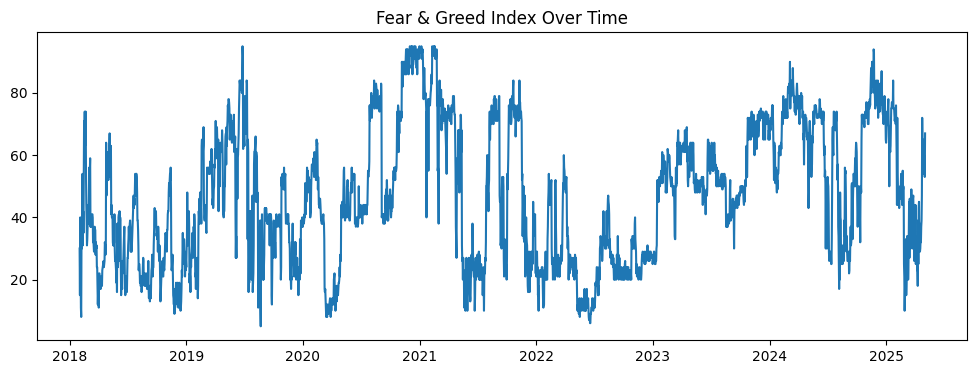

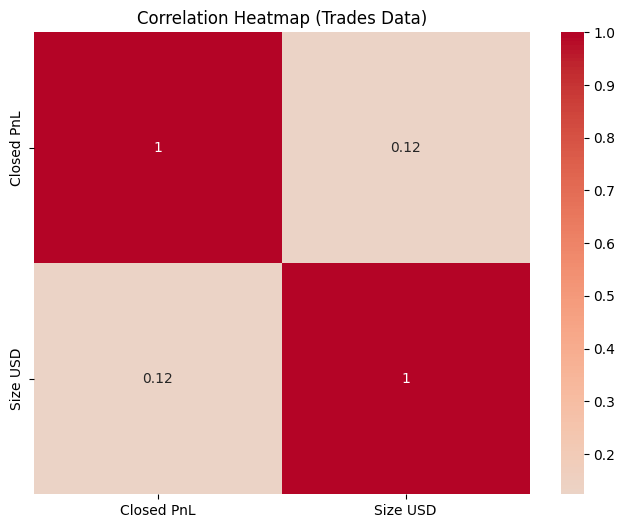

In [ ]:
print("Trades Dataset Overview")
plt.figure(figsize=(12,5))
trades[profit_col].hist(bins=50)
plt.title("Distribution of Profit per Trade")
plt.xlabel("Profit")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(12,5))
trades[volume_col].hist(bins=50)
plt.title("Distribution of Trade Volumes")
plt.xlabel("Volume")
plt.ylabel("Count")
plt.show()

if lev_col:
  plt.figure(figsize=(12,5))
  trades[lev_col].hist(bins=50)
  plt.title("Distribution of Leverage")
  plt.xlabel("Leverage")
  plt.ylabel("Count")
  plt.show()

# Time series of trades count
trades_per_day = trades.groupby(trades[trade_date_col].dt.date).size()
plt.figure(figsize=(12,4))
trades_per_day.plot()
plt.title("Number of Trades per Day")
plt.show()

# FGI dataset
print("\nFGI Dataset Overview")
print(fgi.info())
display(fgi.head())

print("\nSummary Statistics (FGI)")
display(fgi.describe().round(3))

plt.figure(figsize=(12,4))
plt.plot(fgi['date'], fgi['fgi'])
plt.title("Fear & Greed Index Over Time")
plt.show()

# Correlation heatmap of numeric columns in trades
plt.figure(figsize=(8,6))
sns.heatmap(trades[[profit_col, volume_col] + ([lev_col] if lev_col else [])].corr(),annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Trades Data)")
plt.show()

# Aggregate Daily
trades['date'] = trades[trade_date_col].dt.floor('D')
daily = trades.groupby('date').agg(
    total_profit=(profit_col, 'sum'),
    mean_profit=(profit_col, 'mean'),
    trade_count=(profit_col, 'count'),
    volume=(volume_col, 'sum'),
    pnl_std=(profit_col, 'std')
).reset_index()
if lev_col:
  daily['avg_leverage'] = trades.groupby('date')[lev_col].mean().values
else:
  daily['avg_leverage'] = np.nan

Merging

In [ ]:
merged = pd.merge(daily, fgi, on='date', how='left').sort_values('date')
merged['fgi'] = merged['fgi'].ffill().bfill()

Features

In [ ]:
merged['pnl_roll'] = merged['total_profit'].rolling(ROLLING_WINDOW, min_periods=5).sum()
merged['corr_fgi_profit'] = (
    merged['total_profit']
    .rolling(ROLLING_CORR_WINDOW, min_periods=10)
    .corr(merged['fgi'])
)

Correlation Matrix

In [ ]:
corr = merged[['total_profit','mean_profit','pnl_std','volume','avg_leverage','fgi']].corr().round(3)
corr

,total_profit,mean_profit,pnl_std,volume,avg_leverage,fgi
total_profit,1.000,0.548,0.475,0.523,NaN,-0.022
mean_profit,0.548,1.000,0.139,0.121,NaN,-0.003
pnl_std,0.475,0.139,1.000,0.387,NaN,0.080
volume,0.523,0.121,0.387,1.000,NaN,-0.000
avg_leverage,NaN,NaN,NaN,NaN,NaN,NaN
fgi,-0.022,-0.003,0.080,-0.000,NaN,1.000


Lagged Correlation

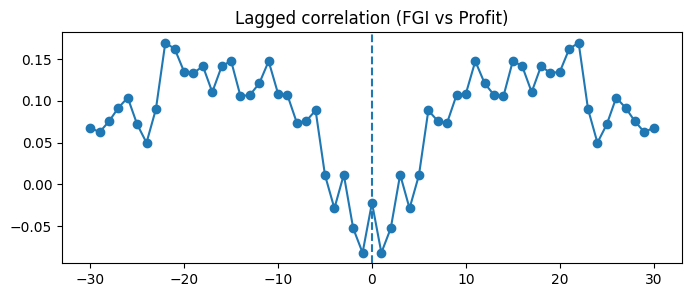

In [ ]:
lag_corr = {}
for lag in range(-MAX_LAG, MAX_LAG+1):
  if lag < 0:
    ser1 = merged['fgi']
    ser2 = merged['total_profit'].shift(lag)
  else:
    ser1 = merged['fgi'].shift(lag)
    ser2 = merged['total_profit']
  valid = ser1.notna() & ser2.notna()
  lag_corr[lag] = np.corrcoef(ser1[valid], ser2[valid])[0,1] if valid.sum()>10 else np.nan
lag_corr = pd.Series(lag_corr)
lag_corr.plot(title="Lagged correlation (FGI vs Profit)", figsize=(8,3), marker='o')
plt.axvline(0, linestyle='--')
plt.show()

Regime Stats

In [ ]:
regimes = pd.cut(merged['fgi'], bins=REGIME_BINS, labels=['Fear','Neutral','Greed'])
merged['regime'] = regimes

regime_stats = merged.groupby('regime', observed=False).agg(
    days=('date','count'),
    mean_total_profit=('total_profit','mean'),
    median_total_profit=('total_profit','median'),
    profit_std=('total_profit','std'),
    mean_volume=('volume','mean')
).round(3)

regime_stats

,days,mean_total_profit,median_total_profit,profit_std,mean_volume
regime,,,,,
Fear,38,34070.008,766.261,116210.157,1735353.966
Neutral,27,29627.268,241.242,85110.094,1573981.063
Greed,123,29141.207,968.590,89157.165,2881410.792


Risk Adjusted Matrics

In [ ]:
def sharpe(series, period_days=252):
  return (series.mean()/series.std())*np.sqrt(period_days) if series.std()>0 else np.nan

merged['cum_profit'] = merged['total_profit'].cumsum()
roll_max = np.maximum.accumulate(merged['cum_profit'])
drawdown = merged['cum_profit'] - roll_max

risk_summary = {
    'Sharpe_daily' : sharpe(merged['total_profit'].dropna()),
    'Max_drawdown' : drawdown.min()
}
risk_summary

{'Sharpe_daily': np.float64(5.091826292587483), 'Max_drawdown': -122672.000883}

Plots

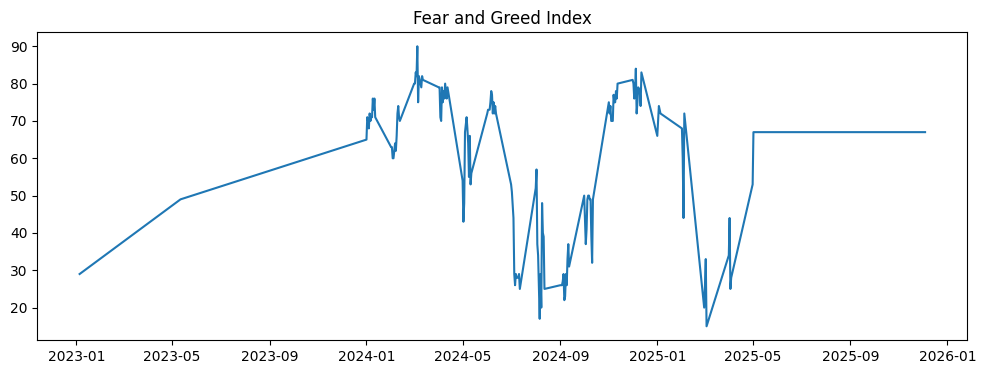

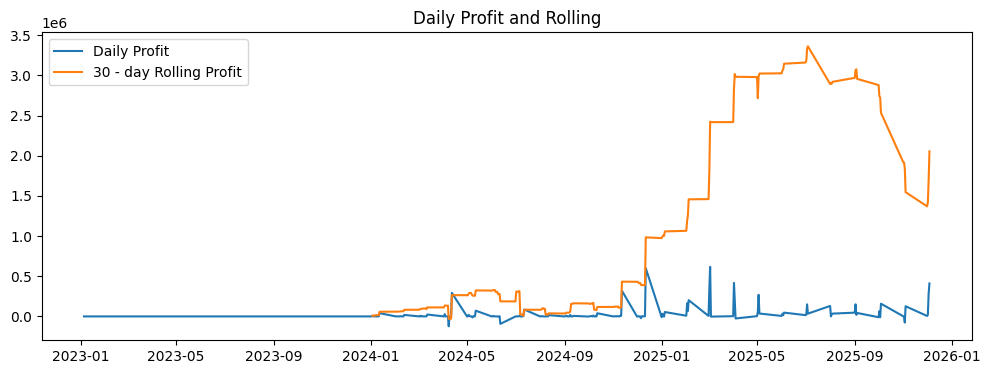

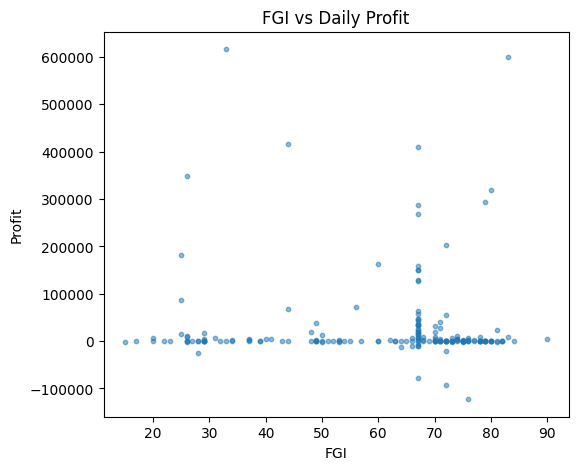

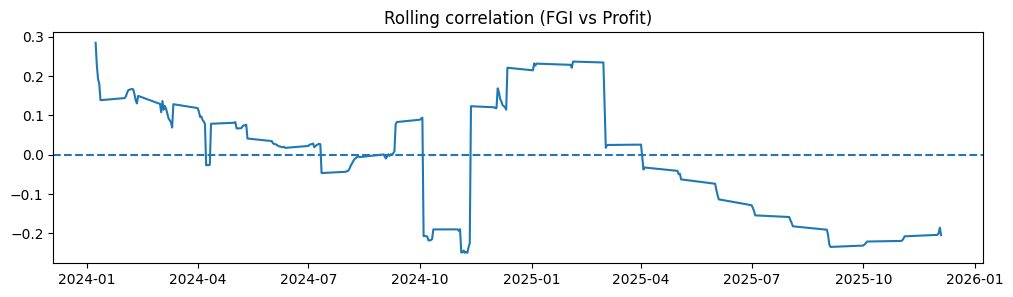

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(merged['date'],merged['fgi'])
plt.title('Fear and Greed Index')
plt.show()

plt.figure(figsize=(12,4))
plt.plot(merged['date'], merged['total_profit'], label='Daily Profit')
plt.plot(merged['date'], merged['pnl_roll'], label=f'{ROLLING_WINDOW} - day Rolling Profit')
plt.legend(); plt.title('Daily Profit and Rolling'); plt.show()

plt.figure(figsize=(6,5))
plt.scatter(merged['fgi'], merged['total_profit'], s=10, alpha=0.5)
plt.title('FGI vs Daily Profit'); plt.xlabel('FGI'); plt.ylabel('Profit')
plt.show()

plt.figure(figsize=(12,3))
plt.plot(merged['date'], merged['corr_fgi_profit'])
plt.axhline(0, linestyle='--')
plt.title('Rolling correlation (FGI vs Profit)')
plt.show()

Downloading merged dataset

In [ ]:
from google.colab import files
merged
merged.to_csv("merged_data.csv", index = False)
files.download("merged_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>